In [1]:
# general imports
import pandas as pd
import requests
import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load in files
keywords_df = pd.read_csv('data/keywords.csv')
movies_metadata_df = pd.read_csv('data/movies_metadata.csv')
bechdel_movies = pd.read_csv('data/bechdel_movies.csv')

C:\Users\owner\AppData\Local\Temp\ipykernel_29960\4157074776.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata_df = pd.read_csv('data/movies_metadata.csv')


## Data Cleaning and Wrangling

Leave cells below commented, the cleaned and wrangled data has been uploaded into the `data` folder under `bechdel_movies.csv`, and has been stored in the the `bechdel_movies` variable.

In [3]:
# # General cleaning 

# # dropping unecessary columns from movies_metadata
# movies_metadata_df = movies_metadata_df.drop(columns = ['belongs_to_collection', 'homepage', 
#                                                         'poster_path', 'status', 'tagline', 
#                                                         'video', 'spoken_languages', 'vote_average', 
#                                                         'vote_count'])
# movies_metadata_df['id'] = pd.to_numeric(movies_metadata_df['id'] , downcast='integer', errors='coerce')

# # get average rating by 'movieId', drop unecessary columns, rename 'movieId'
# avg_rating = ratings_df.groupby('movieId').mean().reset_index()
# avg_rating = avg_rating.drop(columns = ['userId', 'timestamp'])
# avg_rating = avg_rating.rename(columns = {'movieId': 'id'})

# # joining movies_metadata_df and keywords_df together
# joined_df = pd.merge(movies_metadata_df, keywords_df, on='id', how='inner')
# # drop rows where 'id' or 'imdb_id' is NaN
# joined_df = joined_df.dropna(subset=['id', 'imdb_id'])

# # function to clean imdb_id of leading 'tt' for API calls
# def clean_imbd(imdb_ids):
#     return imdb_ids.replace('t', '')

# # apply function to imdb_id column 
# joined_df['imdb_id'] = joined_df['imdb_id'].apply(clean_imbd)

In [4]:
## Bechdel Test API Call - leave commented to avoid rerunning unecessarily 
## resulting .json can be found in data folder: 'data/bechdel_scores.json'

# url = "http://bechdeltest.com/api/v1/getAllMovies"
# response = requests.get(url)
# bechdel_scores = response.json()
# file_path = "bechdel_scores.json"

# with open(file_path, 'w') as json_file:
#     json.dump(bechdel_scores, json_file, indent=4)

# print(f"JSON data written to {file_path}")

In [5]:
# # create a pandas DataFrame with imdb_id and respective bechdel_score
# imdb_bechdel = {}
# for movie in bechdel_scores:
#     imdb_bechdel[movie['imdbid']] = movie['rating']
# bechdel_df = pd.DataFrame()
# bechdel_df['imdb_id'] = imdb_bechdel.keys()
# bechdel_df['bechdel_score'] = imdb_bechdel.values()

# # merge bechdel with movie dataset
# bechdel_movies = pd.merge(joined_df, bechdel_df, on='imdb_id', how='inner')

# extract names from columns with a list of dictionaries - returns a list with names
# def get_names(cell):
#     if pd.isna(cell):
#         return []
#     if isinstance(cell, str):
#         try:
#             cell = ast.literal_eval(cell)
#         except (ValueError, SyntaxError):
#             return []
#     names = []
#     for d in cell:
#         if isinstance(d, dict) and 'name' in d:
#             names.append(d['name'])
#     return names


# columns_to_clean = ['genres', 'production_companies', 'production_countries', 'keywords']
# for column in columns_to_clean:
#     bechdel_movies[column] = bechdel_movies[column].apply(get_names)

## Write DataFrame to .csv file - Leave commented
## resulting .csv can be found in data folder: 'data/bechdel_movies.csv'

#bechdel_movies.to_csv('bechdel_movies.csv', index=False, sep=',', na_rep='', encoding='utf-8')

In [6]:
# convert release_date to datetime object
bechdel_movies['release_date'] = pd.to_datetime(bechdel_movies['release_date'])

In [7]:
bechdel_movies.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,title,keywords,bechdel_score
0,False,30000000,"['Animation', 'Comedy', 'Family']",862.0,114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,['Pixar Animation Studios'],['United States of America'],1995-10-30,373554033.0,81.0,Toy Story,"['jealousy', 'toy', 'boy', 'friendship', 'frie...",1
1,False,65000000,"['Adventure', 'Fantasy', 'Family']",8844.0,113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],1995-12-15,262797249.0,104.0,Jumanji,"['board game', 'disappearance', ""based on chil...",3
2,False,0,"['Romance', 'Comedy']",15602.0,113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"['Warner Bros.', 'Lancaster Gate']",['United States of America'],1995-12-22,0.0,101.0,Grumpier Old Men,"['fishing', 'best friend', 'duringcreditssting...",3
3,False,16000000,"['Comedy', 'Drama', 'Romance']",31357.0,114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,['Twentieth Century Fox Film Corporation'],['United States of America'],1995-12-22,81452156.0,127.0,Waiting to Exhale,"['based on novel', 'interracial relationship',...",2
4,False,60000000,"['Action', 'Crime', 'Drama', 'Thriller']",949.0,113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"['Regency Enterprises', 'Forward Pass', 'Warne...",['United States of America'],1995-12-15,187436818.0,170.0,Heat,"['robbery', 'detective', 'bank', 'obsession', ...",2


In [8]:
bechdel_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8069 entries, 0 to 8068
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 8069 non-null   bool          
 1   budget                8069 non-null   int64         
 2   genres                8069 non-null   object        
 3   id                    8069 non-null   float64       
 4   imdb_id               8069 non-null   int64         
 5   original_language     8068 non-null   object        
 6   original_title        8069 non-null   object        
 7   overview              8060 non-null   object        
 8   popularity            8069 non-null   float64       
 9   production_companies  8069 non-null   object        
 10  production_countries  8069 non-null   object        
 11  release_date          8068 non-null   datetime64[ns]
 12  revenue               8069 non-null   float64       
 13  runtime           

## Exploratory Data Analysis & Visualization

In [9]:
print("Shape of dataset:", bechdel_movies.shape)
print("\nColumns:", bechdel_movies.columns.tolist())
print("\nMissing values:\n", bechdel_movies.isnull().sum())
print("\nData types:\n", bechdel_movies.dtypes)

Shape of dataset: (8069, 17)

Columns: ['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'title', 'keywords', 'bechdel_score']

Missing values:
 adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       1
original_title          0
overview                9
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 0
title                   0
keywords                0
bechdel_score           0
dtype: int64

Data types:
 adult                             bool
budget                           int64
genres                          object
id                             float64
imdb_id                          int64
original_language               object
orig

### Descriptive Statistics

In [10]:
print("\nSummary statistics:\n", bechdel_movies.describe(include='all'))


Summary statistics:
         adult        budget     genres             id       imdb_id  \
count    8069  8.069000e+03       8069    8069.000000  8.069000e+03   
unique      1           NaN       1634            NaN           NaN   
top     False           NaN  ['Drama']            NaN           NaN   
freq     8069           NaN        798            NaN           NaN   
mean      NaN  1.768414e+07        NaN   69303.524352  8.860859e+05   
min       NaN  0.000000e+00        NaN       5.000000  3.000000e+00   
25%       NaN  0.000000e+00        NaN    9737.000000  9.063300e+04   
50%       NaN  2.500000e+05        NaN   23834.000000  3.125280e+05   
75%       NaN  2.000000e+07        NaN   75233.000000  1.411238e+06   
max       NaN  3.800000e+08        NaN  461615.000000  6.536944e+06   
std       NaN  3.574542e+07        NaN  100475.599835  1.164649e+06   

       original_language   original_title            overview   popularity  \
count               8068             8069      

In [21]:
# Get counts for each Bechdel score category
bechdel_summary = bechdel_movies['bechdel_score'].value_counts().sort_index()

print("Bechdel Score Summary:")
print(bechdel_summary)

# Proportions
bechdel_proportions = bechdel_movies['bechdel_score'].value_counts(normalize=True).sort_index()

print("\nProportion of Each Bechdel Score:")
print(bechdel_proportions)

Bechdel Score Summary:
bechdel_score
0     879
1    1875
2     879
3    4436
Name: count, dtype: int64

Proportion of Each Bechdel Score:
bechdel_score
0    0.108935
1    0.232371
2    0.108935
3    0.549758
Name: proportion, dtype: float64


In [23]:
### Counts and Proportions by Decade

# extract year
bechdel_movies['release_year'] = bechdel_movies['release_date'].dt.year

# Drop rows where year or score is missing
df = bechdel_movies.dropna(subset=['release_year', 'bechdel_score'])

# Create a 'decade' column
df['decade'] = ((df['release_year'] // 10) * 10).astype(int)

# Count of observations by Bechdel score and decade
counts_by_decade = df.groupby(['decade', 'bechdel_score']).size().unstack(fill_value=0)

# Proportions of each Bechdel score per decade
proportions_by_decade = counts_by_decade.div(counts_by_decade.sum(axis=1), axis=0)

# Display results
print("Counts by Decade:")
print(counts_by_decade)

print("\nProportions by Decade:")
print(proportions_by_decade)

Counts by Decade:
bechdel_score    0    1    2     3
decade                            
1870             2    0    0     0
1880             4    0    0     0
1890            31    1    0     1
1900            20    1    0     0
1910             5    0    2     5
1920            31   10   17    14
1930            20   36   36    92
1940            36   43   33   113
1950            44   65   48   145
1960            72  109   46   181
1970            68  125   56   195
1980            93  158   83   341
1990            96  288  125   592
2000           177  504  200  1250
2010           180  534  233  1506
2020             0    0    0     1

Proportions by Decade:
bechdel_score         0         1         2         3
decade                                               
1870           1.000000  0.000000  0.000000  0.000000
1880           1.000000  0.000000  0.000000  0.000000
1890           0.939394  0.030303  0.000000  0.030303
1900           0.952381  0.047619  0.000000  0.000000
1910

C:\Users\owner\AppData\Local\Temp\ipykernel_29960\2155582448.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decade'] = ((df['release_year'] // 10) * 10).astype(int)


In [31]:
## Count of films per genre

# Convert 'genres' column from string to list
bechdel_movies['genres_list'] = bechdel_movies['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])

# Flatten the list of genres across all rows
all_genres = [genre for sublist in bechdel_movies['genres_list'] for genre in sublist]

# Create a Series and count occurrences
genre_counts = pd.Series(all_genres).value_counts()

# Display the top genres
print("Film Counts by Genre:")
print(genre_counts)


Film Counts by Genre:
Drama              4217
Comedy             2830
Thriller           1807
Romance            1565
Action             1494
Adventure          1117
Horror              981
Crime               954
Science Fiction     883
Family              748
Fantasy             733
Mystery             585
Animation           527
Music               360
History             301
War                 240
Western             151
Documentary         101
Foreign              90
TV Movie             77
Name: count, dtype: int64


### Exploratory Data Visualization

C:\Users\owner\AppData\Local\Temp\ipykernel_29960\1345785609.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=bechdel_movies, x='bechdel_score', palette=custom_palette)


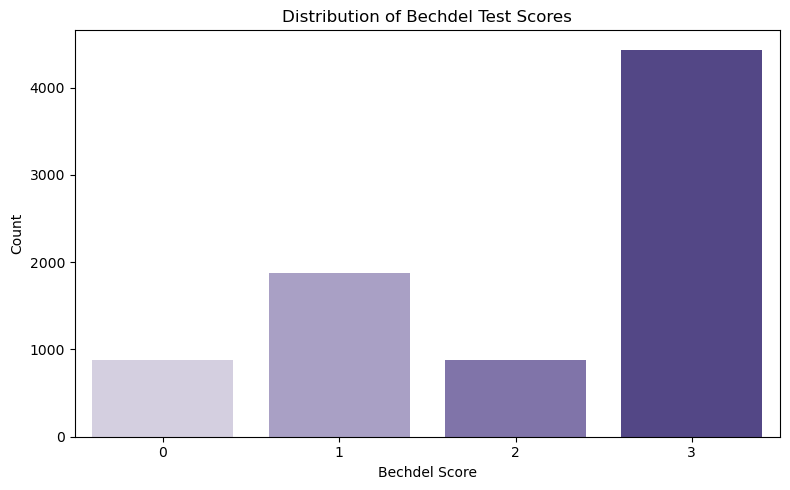

In [43]:
## Distribution of Bechdel Scores

# Custom monochrome purple-blue palette
custom_palette = {
    '0': "#d3cce3",  # light lavender
    '1': "#a69acb",  # soft purple
    '2': "#7b6bb2",  # medium purple-blue
    '3': "#4c3c91",  # darkest purple-blue
}

plt.figure(figsize=(8, 5))
sns.countplot(data=bechdel_movies, x='bechdel_score', palette=custom_palette)
plt.title('Distribution of Bechdel Test Scores')
plt.xlabel('Bechdel Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

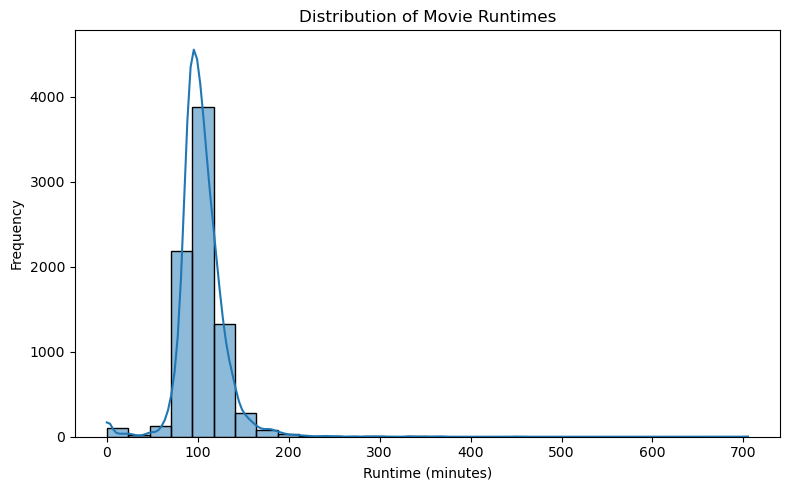

In [12]:
# Histogram of movie runtimes (if available)
if 'runtime' in bechdel_movies.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(bechdel_movies['runtime'].dropna(), bins=30, kde=True)
    plt.title('Distribution of Movie Runtimes')
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

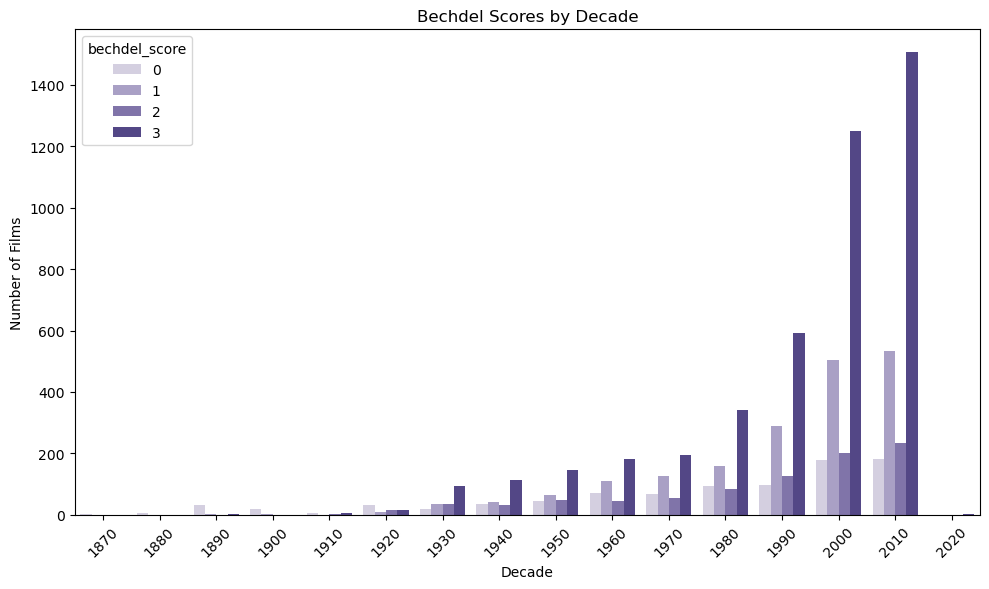

In [35]:
## Bechdel score by decade ('release_date')

# Define your custom purple-blue monochrome palette
custom_palette = {
    0: "#d3cce3",  # lightest
    1: "#a69acb",  # light
    2: "#7b6bb2",  # medium
    3: "#4c3c91",  # darkest
}

# Bechdel score by decade with custom colors
if 'release_date' in bechdel_movies.columns:
    bechdel_movies['release_year'] = pd.to_datetime(bechdel_movies['release_date'], errors='coerce').dt.year
    bechdel_movies['decade'] = ((bechdel_movies['release_year'] // 10) * 10).astype('Int64')
    
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=bechdel_movies,
        x='decade',
        hue='bechdel_score',
        palette=custom_palette
    )
    plt.title('Bechdel Scores by Decade')
    plt.xlabel('Decade')
    plt.ylabel('Number of Films')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

C:\Users\owner\AppData\Local\Temp\ipykernel_29960\375780507.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


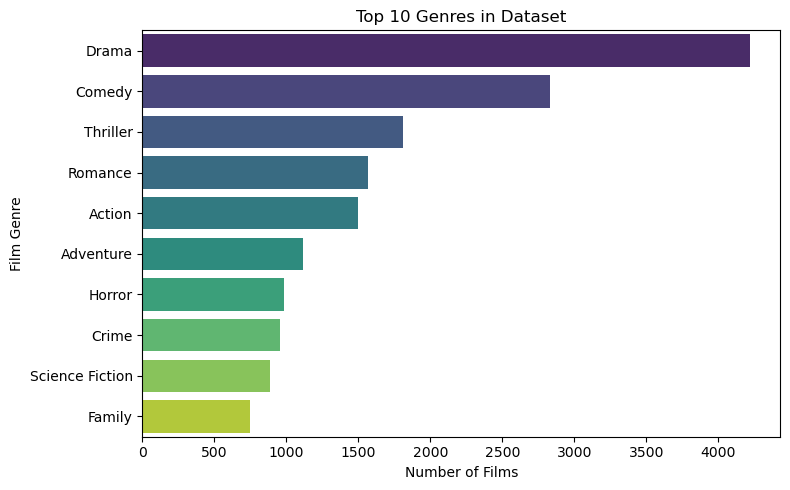

In [29]:
# Top genres
if 'genres' in bechdel_movies.columns and bechdel_movies['genres'].apply(lambda x: isinstance(x, str)).any():
    from ast import literal_eval
    bechdel_movies['genres_list'] = bechdel_movies['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])
    genre_counts = pd.Series([genre for sublist in bechdel_movies['genres_list'] for genre in sublist]).value_counts().head(10)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
    plt.title('Top 10 Genres in Dataset')
    plt.xlabel('Number of Films')
    plt.ylabel('Film Genre')
    plt.tight_layout()
    plt.show()

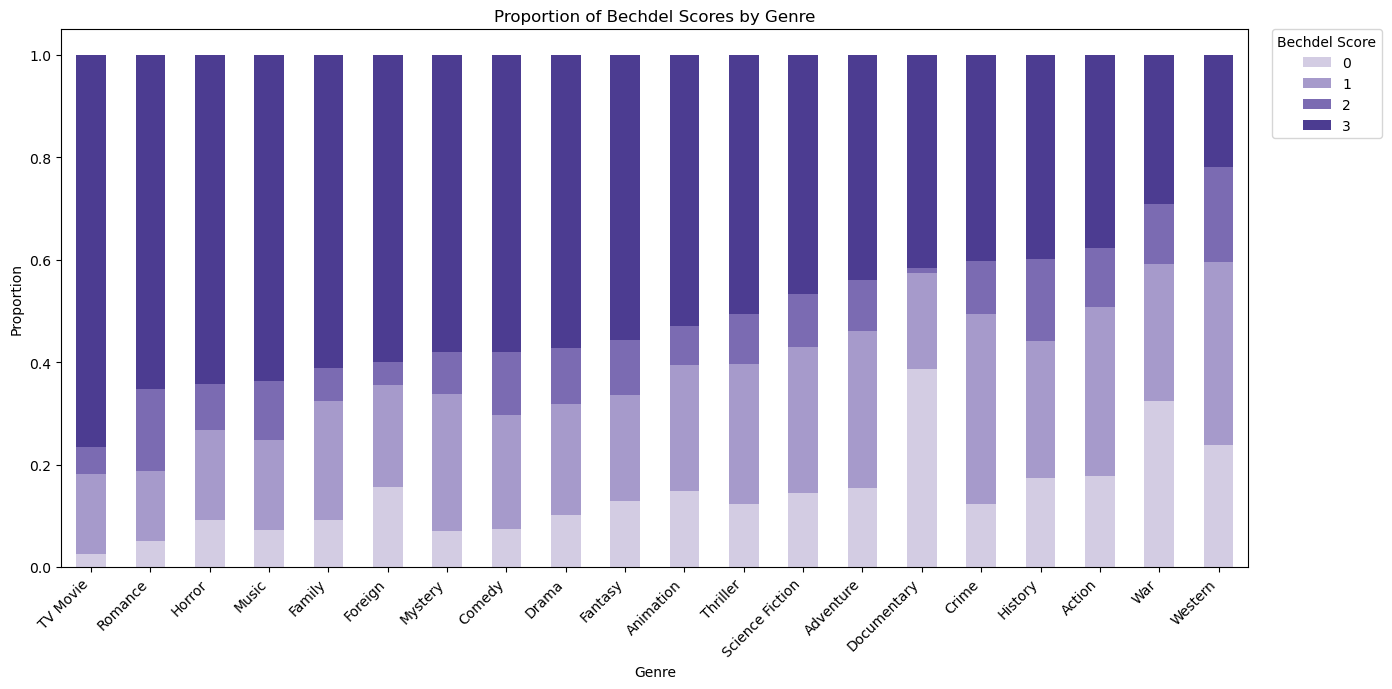

In [34]:
## Stacked Barlplot for Bachdel Score Distribution for each genre

# Explode the dataframe so each genre is its own row
exploded_df = bechdel_movies.explode('genres_list')

# Drop rows with missing Bechdel scores or genres
exploded_df = exploded_df.dropna(subset=['bechdel_score', 'genres_list'])

# Group by genre and Bechdel score, count, then normalize by genre
genre_score_counts = exploded_df.groupby(['genres_list', 'bechdel_score']).size().unstack(fill_value=0)
genre_score_props = genre_score_counts.div(genre_score_counts.sum(axis=1), axis=0)

# Sort genres for readability
genre_score_props = genre_score_props.sort_values(by=3, ascending=False)  # Sort by proportion of score 3


# Define custom monochrome purple-blue shades for Bechdel scores 0–3
custom_colors = {
    0: "#d3cce3",  # light lavender
    1: "#a69acb",  # soft purple
    2: "#7b6bb2",  # medium purple-blue
    3: "#4c3c91",  # darkest purple-blue
}

# Reorder columns to ensure consistent color mapping
genre_score_props = genre_score_props[[0, 1, 2, 3]]

# Plot with custom colors
ax = genre_score_props.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    color=[custom_colors[i] for i in genre_score_props.columns]
)

plt.title('Proportion of Bechdel Scores by Genre')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')

# Move legend outside
plt.legend(
    title='Bechdel Score',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()